### Import libraries

In [1]:
import os
import pandas as pd

import tensorflow as tf
from keras import regularizers

import spacy
en = spacy.load('en_core_web_sm')
sw_spacy = en.Defaults.stop_words

import string
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_auc_score,roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Read dataset

In [2]:
path_to_dataset = ""
file_name = "daigt_v3.csv"

if os.path.exists('/content/'):
        path_to_dataset = f"/content/{file_name}"

if os.path.exists('/kaggle/input/'):
        path_to_dataset = f"/kaggle/input/daigt-v3/{file_name}"

df = pd.read_csv(path_to_dataset)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43602 entries, 0 to 43601
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   text           43602 non-null  object 
 1   label          43602 non-null  float64
 2   prompt_name    43602 non-null  object 
 3   source         43602 non-null  object 
 4   RDizzl3_seven  43602 non-null  bool   
 5   id             43602 non-null  float64
dtypes: bool(1), float64(2), object(3)
memory usage: 1.7+ MB


## Data preprocessing

In [3]:
df = df.drop("prompt_name", axis = 1)
df = df.drop("source", axis = 1)
df = df.drop("RDizzl3_seven", axis = 1)
df = df.drop("id", axis = 1)

### Function to remove stop words (it also make the sentences lower)
Just as proof of our operation and to do it also in the test_essays generated by Kaggle.
Our dataset is already pre-processed.



In [4]:
def remove_stop_words_spacy(text):
    if not isinstance(text, str) or not text:
        return ""
    words = [word for word in text.split() if word.lower() not in sw_spacy]
    new_text = " ".join(words)
    return new_text.lower()

In [5]:
print(len(df['text'][0]))

2029


In [6]:
df['text']=df['text'].apply(remove_stop_words_spacy)

In [7]:
print(len(df['text'][0]))

1070


## Train test split

In [8]:
X_train, X_temp, y_train, y_temp = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle = True)

In [9]:
train_data = pd.DataFrame({'text': X_train, 'label': y_train})
train_dataset = tf.data.Dataset.from_tensor_slices((train_data['text'], train_data['label']))

## Model

### Create TextVectorization layer

#### OUTPUT_SEQUENCE_LENGTH CHOICE

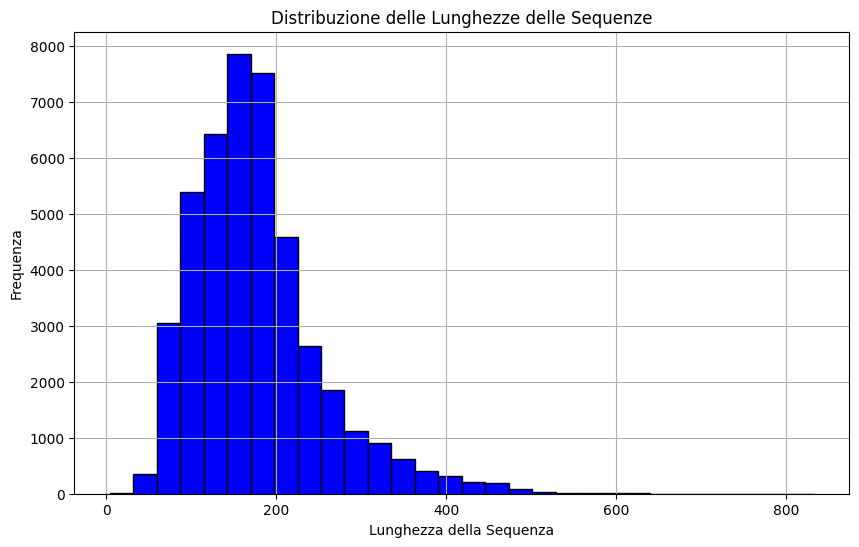

In [10]:
df['sequence_length'] = df['text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
plt.hist(df['sequence_length'], bins=30, color='blue', edgecolor='black')
plt.title('Distribuzione delle Lunghezze delle Sequenze')
plt.xlabel('Lunghezza della Sequenza')
plt.ylabel('Frequenza')
plt.grid(True)
plt.show()

df = df.drop('sequence_length',axis=1)

#### MAX_TOKENS CHOICE

In [11]:
def count_words(text):
    words = word_tokenize(text)
    words = [word.lower() for word in words if word.isalpha()]
    return words

all_list = []
for index,row in df.iterrows():
  a = count_words(row['text'])
  all_list.extend(a)

print(f"Tutte le parole nel dataset: {len(all_list)}")
freq_dist = FreqDist(all_list)
print(f"Parole distinte: {len(freq_dist.most_common())}")


Tutte le parole nel dataset: 7536215
Parole distinte: 73867


In [12]:
freq_dist_custom=[]
FREQUENCY_THRESHOLD = 40
for item in freq_dist.most_common():
    if item[1] >= FREQUENCY_THRESHOLD:
        freq_dist_custom.append(item)
print(len(freq_dist_custom))

7689


In [13]:
VOCAB_SIZE = 8000
encoder = tf.keras.layers.TextVectorization(
    output_sequence_length=500,
    standardize=None,
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

### Create model

In [14]:
model = tf.keras.Sequential([
        encoder,
        tf.keras.layers.Embedding(
            input_dim=len(encoder.get_vocabulary()),
            output_dim=3000,
            mask_zero=True),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
            units=16,
            return_sequences=True)),
        tf.keras.layers.Dropout(rate=0.5),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
            units=16)),
        tf.keras.layers.Dense(
            units=8,
            activation = 'relu',
            kernel_regularizer = regularizers.l1(0.1)),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

In [15]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## Training

In [16]:
history = model.fit(X_train, y_train, epochs=3, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/3
1091/1091 [==============================] - 201s 161ms/step - loss: 0.9239 - accuracy: 0.9716 - val_loss: 0.2958 - val_accuracy: 0.9878
Epoch 2/3
1091/1091 [==============================] - 121s 111ms/step - loss: 0.2499 - accuracy: 0.9881 - val_loss: 0.2167 - val_accuracy: 0.9865
Epoch 3/3
1091/1091 [==============================] - 114s 104ms/step - loss: 0.1862 - accuracy: 0.9922 - val_loss: 0.1869 - val_accuracy: 0.9856


## Evaluation

In [20]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

137/137 [==============================] - 12s 36ms/step - loss: 0.1807 - accuracy: 0.9901
Test Loss: 0.18071378767490387
Test Accuracy: 0.990139901638031


In [17]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)
y_test = y_test.astype(int)

report = classification_report(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
print(report)
print("****")
print(accuracy)

137/137 [==============================] - 10s 33ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2594
           1       1.00      0.98      0.99      1767

    accuracy                           0.99      4361
   macro avg       0.99      0.99      0.99      4361
weighted avg       0.99      0.99      0.99      4361

****
0.9901398761751892


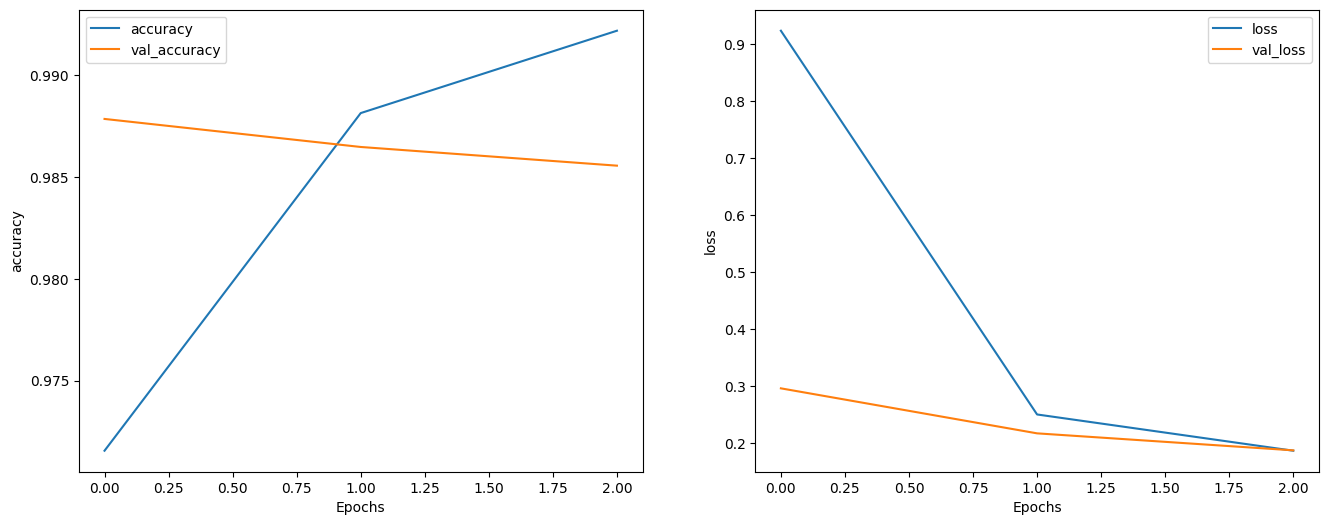

In [21]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

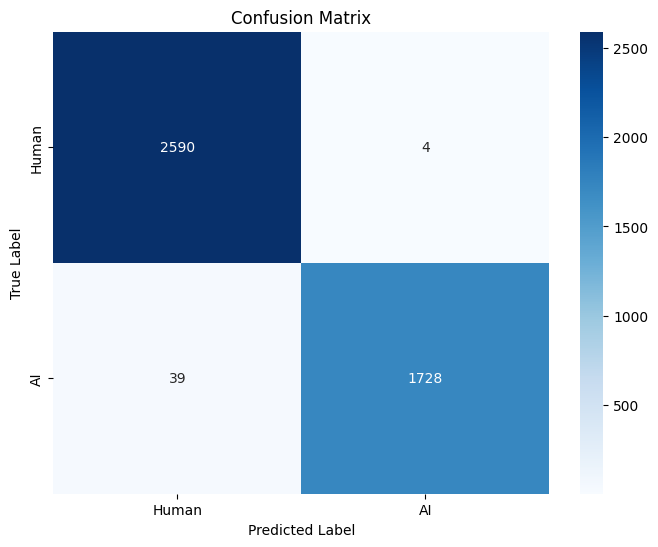

In [18]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Human', 'AI'], yticklabels=['Human', 'AI'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

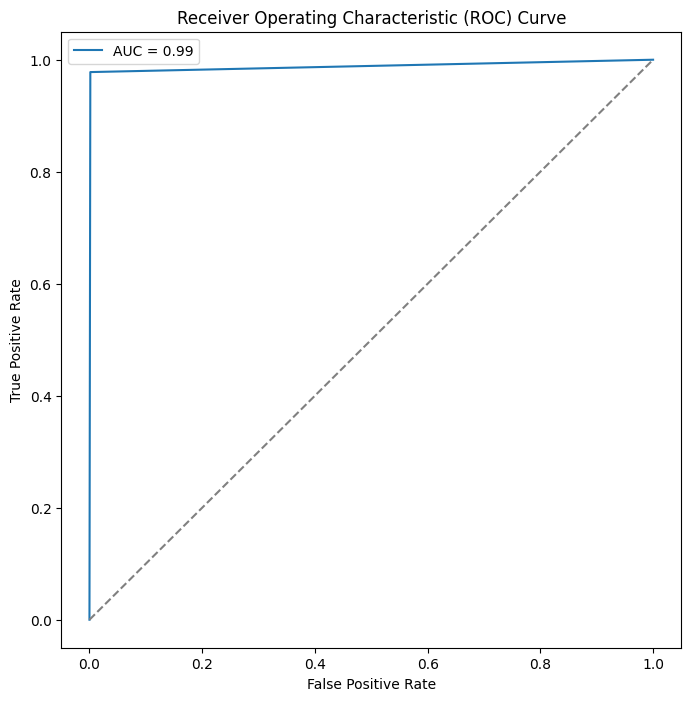

In [19]:
def plot_roc_curve(y_true, y_scores):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    auc_score = roc_auc_score(y_true, y_scores)#

    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

plot_roc_curve(y_test, y_pred)

## Submission

In [ ]:
#test = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/test_essays.csv')
#test['text']=test['text'].apply(remove_stop_words_spacy)
#test.info()
#test_text = test['text'].values

In [ ]:
#predictions = model.predict(test_text)
#test['generated'] = predictions

1/1 [==============================] - 5s 5s/step


In [ ]:
#test[['id', 'generated']].set_index('id').to_csv("submission.csv")